In [1]:
import os
import numpy as np
import math
import h5py
import pandas as pd
import pickle
from random import randrange
import matplotlib.lines as mlines
import utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
plt.rcParams['text.usetex'] = False
# plt.rcParams['text.latex.unicode'] = False
import matplotlib
# important for text to be detecting when importing saved figures into illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
# print(data_dict)

In [2]:
# important arguments
filename = 'VJ_OFCVTA_7_260_D6'
root_dir = r'C:\2pData\Vijay data\VJ_OFCVTA_7_D8_trained'# os.path.abspath("data_2p/full_session-000/")

analysis_win = [0, None]
raw_npilCorr = 1 # 0 for raw vs 1 neuropil corrected signal
fs = 5

rois_to_include = None # [i for i in range(30)] #CZ remove hardcode

In [3]:
# initialize meta variables
sima_h5_path = os.path.join(root_dir, filename + '_sima_mc.h5')

fig_save_dir = os.path.join(root_dir, 'figs')
if not os.path.exists(fig_save_dir):
    os.mkdir(fig_save_dir)

# SIMA 

In [4]:
# load video data
# open h5 to read, find data key, grab data, then close
h5 = h5py.File(sima_h5_path,'r')
sima_data = np.squeeze(np.array( h5[list(h5.keys())[0]] )).astype('int16') # np.array loads all data into memory
h5.close()

In [5]:
manual_data_dims = sima_data.shape

In [6]:
# grab ROI masks from sima (these are probably manually drawn ROIs from imagej)
sima_mask_path = os.path.join(root_dir, filename+'_sima_masks.npy')

sima_masks = np.load(sima_mask_path)
numROI_sima = sima_masks.shape[0]
if not rois_to_include:
    rois_to_include = np.arange(numROI_sima)
num_rois_to_include = len(rois_to_include)

In [7]:
# define number of ROIs to visualize and make colormap for contours
colors_roi = plt.cm.viridis(np.linspace(0,numROI_sima/6,numROI_sima))

In [8]:
# make binary array of roi pixels for contour plotting
zero_template_manual = np.zeros([manual_data_dims[1], manual_data_dims[2]])
roi_label_loc_manual = []
roi_signal_sima = np.empty([numROI_sima, sima_data.shape[0]])

 
for iROI in rois_to_include:
    
    # make binary map of ROI pixels
    ypix_roi, xpix_roi = np.where(sima_masks[iROI,:,:] == 1)
    
    if ypix_roi.size == 0:

        roi_label_loc_manual.append( [0, 0] )
        
    else:
        zero_template_manual[ ypix_roi, xpix_roi ] = 1*(iROI+2)

        roi_label_loc_manual.append( [np.min(ypix_roi), np.min(xpix_roi)] )

        if raw_npilCorr == 0:
            # not npil corr signal
            roi_signal_sima[iROI,:] = np.mean(sima_data[:, ypix_roi, xpix_roi  ], axis = 1)
            roi_signal_sima.shape

In [9]:
# load t-series data
if raw_npilCorr == 1:
    roi_signal_sima = np.load(os.path.join(root_dir, filename+'_neuropil_corrected_signals_15_50_beta_0.8.npy'))
    print(roi_signal_sima.shape)
else:
    roi_signal_sima = np.empty([numROI_sima, sima_data.shape[0]])

(61L, 15169L)


In [10]:
# initialize variables for plotting time-series
num_samps = roi_signal_sima.shape[-1]
total_time = num_samps/fs 
tvec = np.linspace(0,total_time,num_samps)

In [11]:
# CZ better document what you are doing here; duplicate of similar block below??
neg_color_names = ['Blues', 'Purples', 'YlGnBu', 'PuBu', 'GnBu']
pos_color_names = ['Oranges', 'Reds', 'YlOrRd', 'YlOrBr', 'OrRd']
neg_colors = []
pos_colors = []
for i in range(0, len(neg_color_names)):   # CZ disambiguate i and j; don't use range
    cmap = matplotlib.cm.get_cmap(neg_color_names[i])
    colors = []
    for j in range(cmap.N):
        rgba = cmap(j)
        colors.append(matplotlib.colors.rgb2hex(rgba))
    neg_colors.append(colors)
        
    cmap2 = matplotlib.cm.get_cmap(pos_color_names[i])
    colors2 = []
    for j in range(cmap2.N):
        rgba = cmap2(j)
        colors2.append(matplotlib.colors.rgb2hex(rgba)) 
    pos_colors.append(colors2)

In [12]:
roi_signals = np.load(os.path.join(root_dir, filename+'_neuropil_corrected_signals_15_50_beta_0.8.npy'))
vector = np.zeros(len(rois_to_include) + 1, dtype=float)

for iROI, counter in enumerate(rois_to_include):
    avg_val = np.mean(roi_signals[iROI:,])
    baseline = np.max(roi_signals[iROI:,])
    vector[counter] = (avg_val - np.min(roi_signals[iROI,:])) / baseline * 100
orig_vector = roi_signals[iROI:,]

std_img = np.std(sima_data, axis = 0)

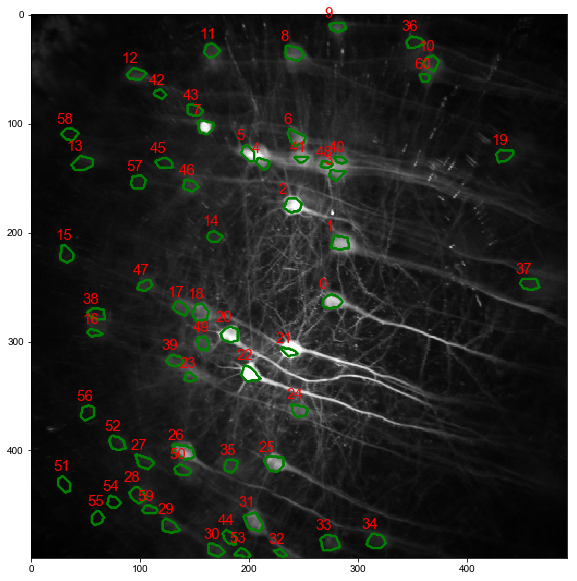

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
climits = [np.min(std_img), np.max(std_img)]
img = ax.imshow(std_img, cmap = 'gray', vmin = climits[0]*1, vmax = climits[1]*0.8)

# CZ major bug!!! tseries for each roi does not correspond to the correct roi contour when rois_to_include is a subset
for iroi in range(numROI_sima):
    cm = plt.contour(sima_masks[iroi,:,:], colors='g')
    plt.text(roi_label_loc_manual[iroi][1] - 5, roi_label_loc_manual[iroi][0] - 5,  int(iroi), fontsize=15, color = 'red')

## Event-related Activity Contour plots

In [14]:
# Creating two lists of lists each of which are rgb values of the
# corresponding color scheme; One for positive activity values and
# the other one for the negative values;
event_one = "minus_unrewarded"
event_two = "plus_rewarded"
neg_color_names = ['Blues', 'Purples', 'YlGnBu', 'PuBu', 'GnBu']
pos_color_names = ['Oranges', 'Greens', 'Reds', 'YlOrRd', 'OrRd']
neg_colors = []
pos_colors = []
for i in range(len(neg_color_names)):    # CZ disambiguate i and j
    cmap = matplotlib.cm.get_cmap(neg_color_names[i])
    colors = []
    # add the rgb values of a color scheme into the list
    for j in range(cmap.N):
        rgba = cmap(j)
        colors.append(matplotlib.colors.rgb2hex(rgba))
    neg_colors.append(colors)
        
    cmap2 = matplotlib.cm.get_cmap(pos_color_names[i])
    colors2 = []
    for j in range(cmap2.N):
        rgba = cmap2(j)
        colors2.append(matplotlib.colors.rgb2hex(rgba))
    pos_colors.append(colors2)

In [15]:
# Loading in the pickle file that contains the dictionary which is
# the data of activity values for different events
pickle_path = os.path.join(root_dir + '/event_rel_analysis/event_data_dict.pkl')
data_dict = np.load(pickle_path, allow_pickle=True)
tvec = np.linspace(-2, 8, data_dict[event_one]['num_samples']) # CZ will need to remove hardcode and pull from meta info later
# CZ UPDATE EVENT-REL-ANALYSIS TO SAVE TVEC TO EVENT_DATA_DICT.PKL

if analysis_win[-1] == None:
    analysis_win[-1] = tvec[-1]
    
# set font size for yticks for the upcoming plots
plt.rc('ytick',labelsize=12)

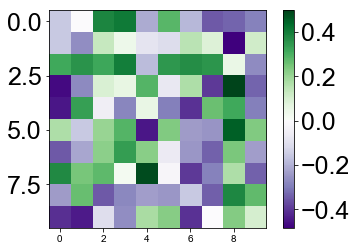

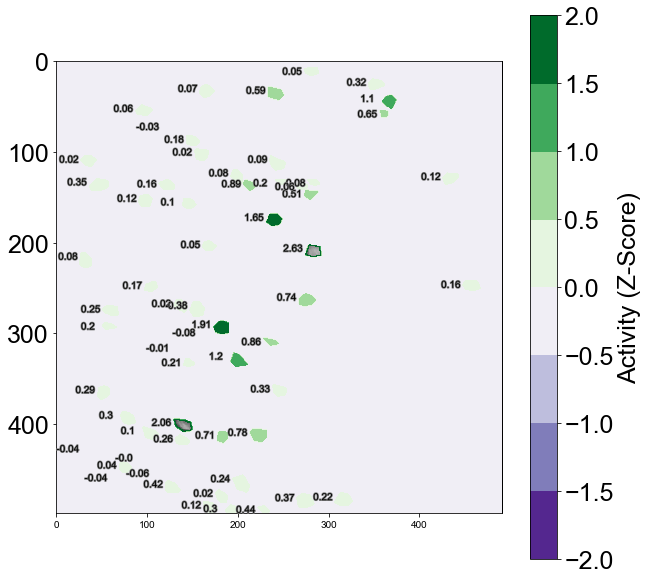

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

data = np.random.rand(10,10)-0.5

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.Purples(np.linspace(1, 0, 128))
colors2 = plt.cm.Greens(np.linspace(0, 1, 128))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

plt.imshow(data, cmap=mymap)
plt.colorbar()
plt.show()

#~~~~~~~~~~~~~~

contour_vector = np.mean(data_dict[event_one]
                                  ['zdata']
                                  [:,:,
                                   utils.get_tvec_sample(tvec, analysis_win[0]):utils.get_tvec_sample(tvec, analysis_win[-1])],
                                  axis=(0,2)) 

# making a copy of the original data vector for coloring purposes
orig_vector = np.copy(contour_vector)


flattened_sima_mask = np.zeros_like(std_img)
for mask_idx, mask in enumerate(sima_masks):
    flattened_sima_mask += mask.astype(int) * contour_vector[mask_idx]

# this all below could be placed into a separate function
fig, ax = plt.subplots(1, 1, figsize = (10,10))
climits = [np.min(std_img), np.max(std_img)]
img = ax.imshow(std_img, cmap = 'gray', vmin = climits[0]*1, vmax = climits[1]*0.8)

# plotting the contours and color them based on each cell's activity value
color_spacing = np.linspace(-2,2,9, endpoint=True)
cm = plt.contour(flattened_sima_mask, cmap=mymap)
cmf = plt.contourf(flattened_sima_mask, color_spacing, cmap=mymap)

cbar = plt.colorbar()
cbar.set_label('Activity (Z-Score)', size = 25)

for iroi in range(numROI_sima):

    # add text that indicates each cell's activity value
    txt = plt.text(roi_label_loc_manual[iroi][1] - 25, roi_label_loc_manual[iroi][0] +7,  
             round(orig_vector[iroi], 2), 
             fontsize=10, 
             color = 'k')
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='gray')])




In [114]:
def plot_contour(data_dict, analysis_win, name, color_idx):
    """
    A function that takes in a name of an event and a index of the color scheme list as
    parameters and uses the corresponding color schemes to plot the event-based activity contour
    plot using the data fetched from the previously loaded in pickle file
    """
    # getting the data corresponding to the activity name from the dictionary
    # CZ tvec needs to be an argument in plot_contour, also correct hardcoding of time selection
    contour_vector = np.mean(data_dict[name]
                                      ['zdata']
                                      [:,:,
                                       utils.get_tvec_sample(tvec, analysis_win[0]):utils.get_tvec_sample(tvec, analysis_win[-1])],
                                      axis=(0,2)) 
    
    # making a copy of the original data vector for coloring purposes
    orig_vector = np.copy(contour_vector)


    
    # normalize the values in the vector so that the colors can be properly indexed
    for i in rois_to_include:
        contour_vector[i] = abs(contour_vector[i])
        contour_vector[i] *= 125
        if (contour_vector[i] >= 255):
            contour_vector[i] = 255

    # this all below could be placed into a separate function
    fig, ax = plt.subplots(1, 1, figsize = (10,10))
    climits = [np.min(std_img), np.max(std_img)]
    img = ax.imshow(std_img, cmap = 'gray', vmin = climits[0]*1, vmax = climits[1]*0.8)

    for iroi in range(numROI_sima):
        
        if orig_vector[iroi] > 0:
            roi_color = pos_colors[color_idx][int(contour_vector[iroi])]
        else:
            roi_color = neg_colors[color_idx][int(contour_vector[iroi])]
        
        # plotting the contours and color them based on each cell's activity value
        cm = plt.contour(sima_masks[iroi,:,:], 
                         colors=roi_color)
        
#         # add text that indicates each cell's activity value
#         txt = plt.text(roi_label_loc_manual[iroi][1] - 25, roi_label_loc_manual[iroi][0] +5,  
#                  round(orig_vector[iroi], 2), 
#                  fontsize=12, 
#                  color = pos_colors[color_idx][int(contour_vector[iroi])]
#                          if orig_vector[iroi] > 0
#                          else neg_colors[color_idx][int(contour_vector[iroi])])
#         txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='gray')])
    

        txt = plt.text(roi_label_loc_manual[iroi][1] - 5, roi_label_loc_manual[iroi][0] - 5,  int(iroi), fontsize=10, color = 'white')
        txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='k')])
    
    plt.title("Activity: " + name, fontsize=15)
    plt.axis('off')

In [105]:
# The main purpose of this function is for sanity check
def plot_activity_subplots(data_dict, analysis_win, name, color_idx):
    """
    A function that takes in a name of an event, and a color index as parameter and
    plot each cell's change of activity corresponding to the specified event across a
    certain time frame as subplots
    """
    
    trial_avg_data = np.mean(data_dict[name]['zdata'], axis=0)
    
    min_max = [np.min(trial_avg_data), np.max(trial_avg_data)]
    
    # CZ these next two lines are the same as in the previous function
    # getting the data corresponding to the activity name from the dictionary
    contour_vector = np.mean(data_dict[name]['zdata']
                                      [:,:,
                                       utils.get_tvec_sample(tvec, analysis_win[0]):utils.get_tvec_sample(tvec, analysis_win[-1])],
                                      axis=(0,2))
    # making a copy of the original data vector for coloring purposes
    orig_vector = np.copy(contour_vector)
    
    # normalize the values in the vector so that the colors can be properly indexed
    for i in rois_to_include:
        contour_vector[i] = abs(contour_vector[i])
        contour_vector[i] *= 125
        if (contour_vector[i] >= 255):
            contour_vector[i] = 255
    
    # plotting each cell's activity as subplots and color each plot based on the cell's
    # activity value
    (fig, axs) = plt.subplots(nrows=6, ncols=5, figsize=(17, 17))
    counter = 0;
    for i in range(6): # CZ hardcode
        for j in range(5):

            if orig_vector[counter] > 0:
                roi_color = pos_colors[color_idx][int(contour_vector[counter])]
            else:
                roi_color = neg_colors[color_idx][int(contour_vector[counter])]
            
            axs[i, j].plot(tvec, trial_avg_data[counter,:], 
                           color=roi_color)
            axs[i, j].set_title("roi " + str(counter), size=20)
            counter += 1
            axs[i, j].tick_params(axis='both', which='major', labelsize=13)
            axs[i, j].tick_params(axis='both', which='minor', labelsize=13)
            axs[i, j].set_ylim(min_max)
            if i == 0 and j == 0:
                axs[i, j].set_xlabel('Time (s)', size=15)
                axs[i, j].set_ylabel('Activity (z-scored)', size=15)
            # Hide the right and top spines
            axs[i, j].spines['right'].set_visible(False)
            axs[i, j].spines['top'].set_visible(False)
            
    fig.tight_layout()
    

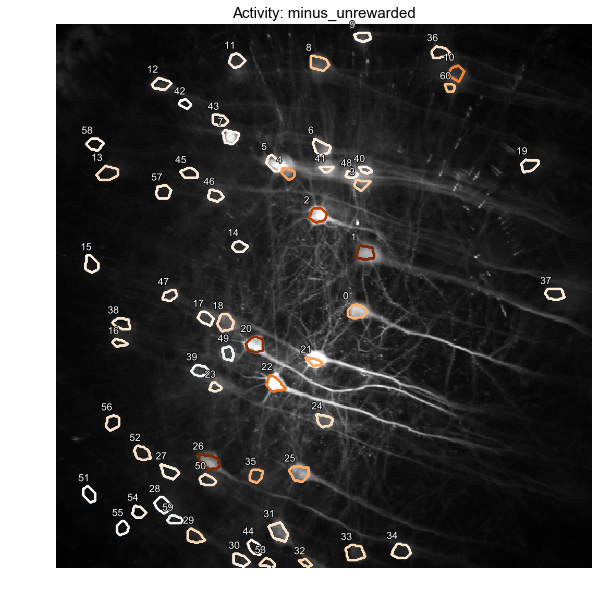

In [115]:
plot_contour(data_dict, analysis_win, event_one, 0)

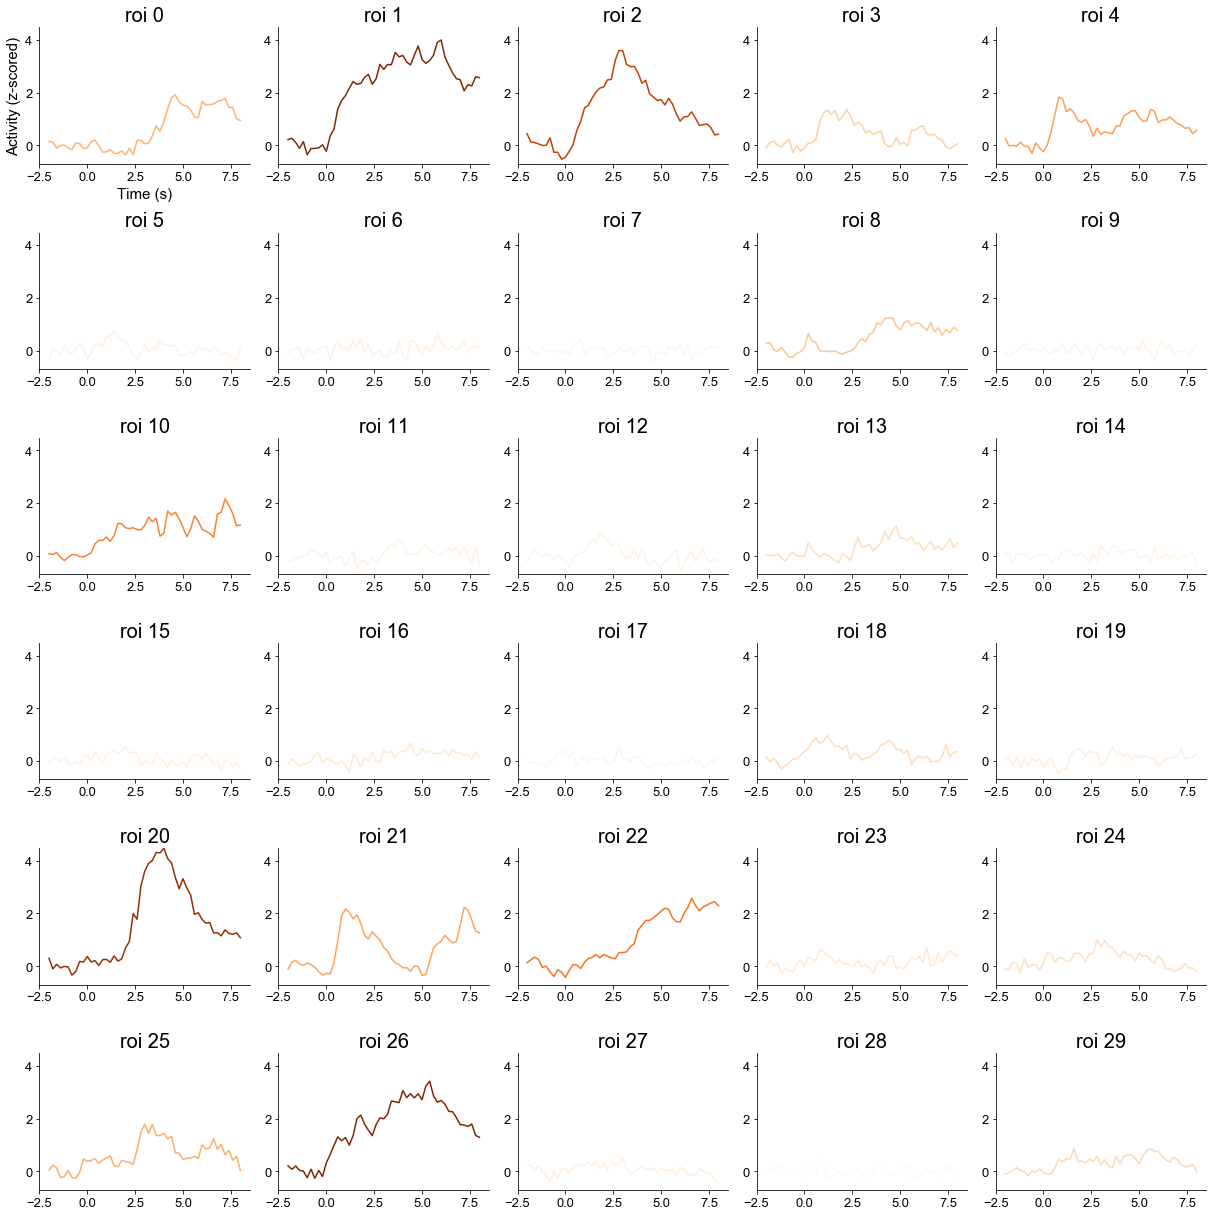

In [106]:
plot_activity_subplots(data_dict, analysis_win, event_one, 0)

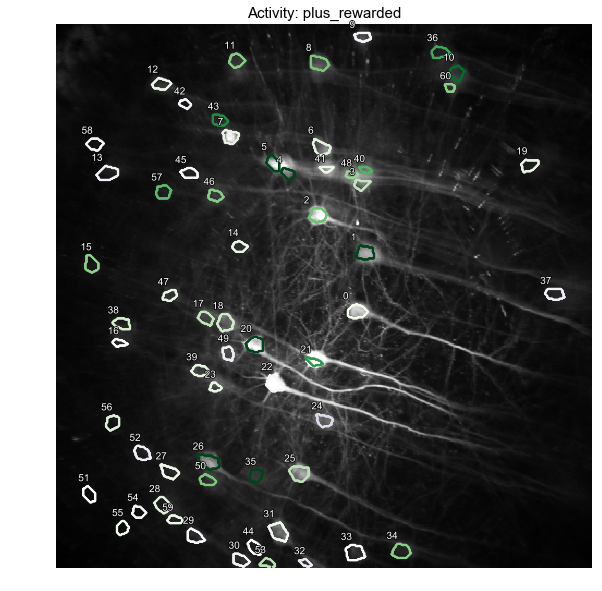

In [116]:
plot_contour(data_dict, analysis_win, event_two, 1)

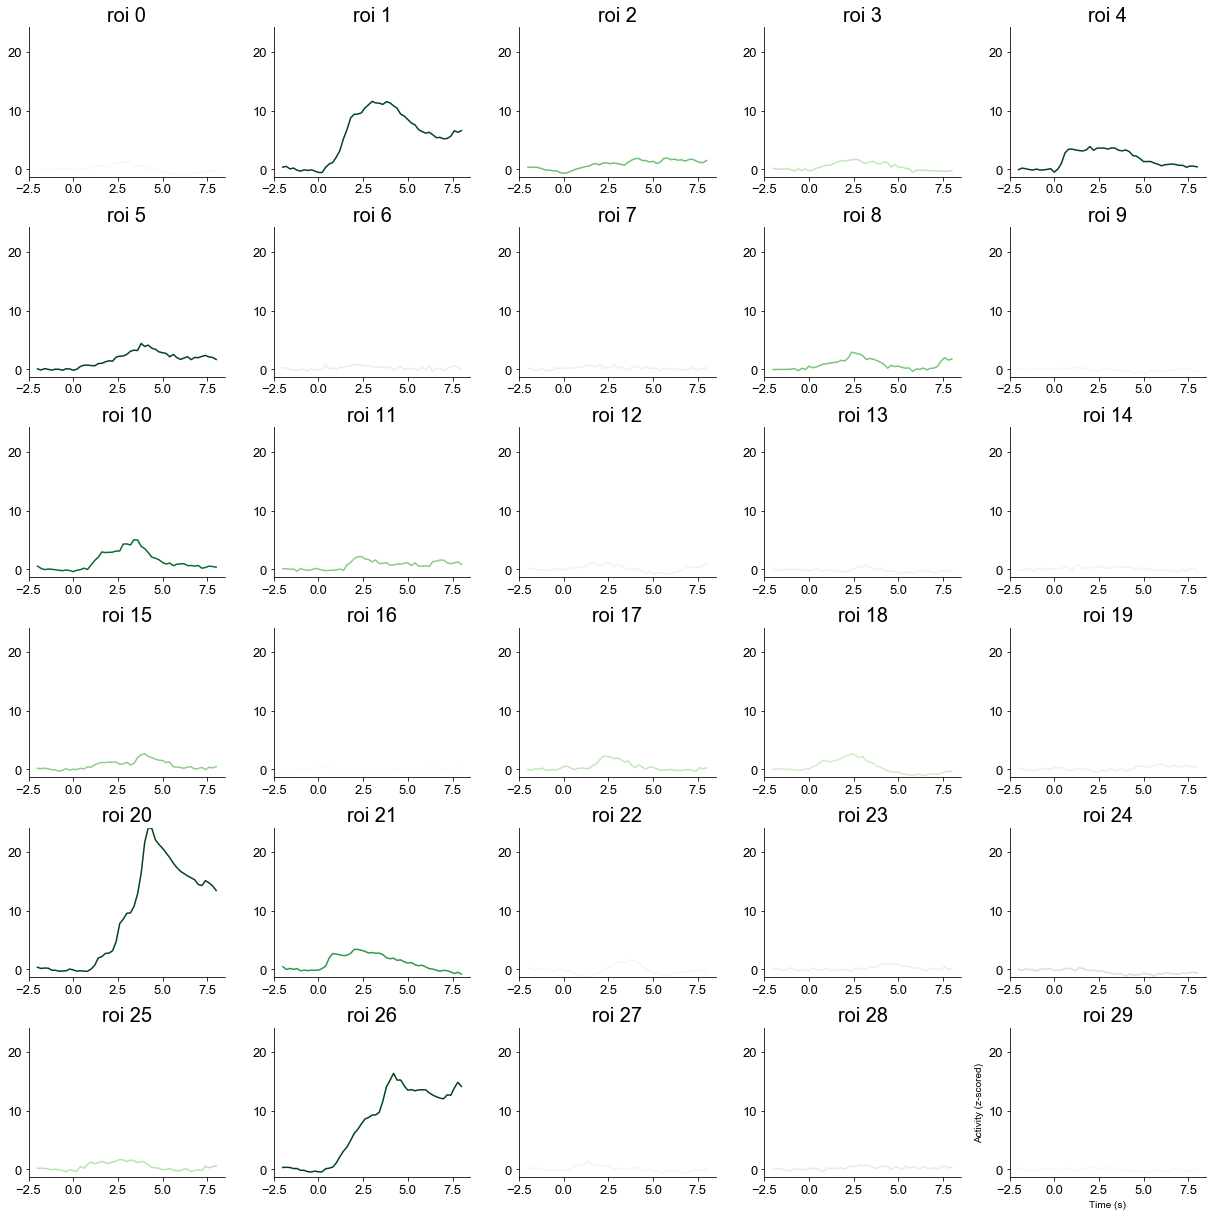

In [91]:
plot_activity_subplots(data_dict, analysis_win, event_two, 1)

### Running the last cell more than once will result in errors due to change of data. If you want to run the last cell for the second time, you have to go back to this cell below and start running the cells from here.

In [23]:
def normalize_vector(vector):
    """
    A function that accepts a data vector as parameter and normalize
    its values in order to make them meaningful indices for coloring purposes
    """
    for i in rois_to_include:
        vector[i] = abs(vector[i])
        vector[i] *= 80
        if (vector[i] >= 255):
            vector[i] = 255

In [24]:
def add_text(axs, axs_idx, roi_idx, event_name1, event_name2):
    """
    A function that takes a matplotlib axes object, an integer index for color schemes,
    two event names and a boolean that indicates whether or not we are handling the
    first half of the data as parameters. It adds texts onto the barplot that indicates
    each cell's activity value;
    """

    for i, v in zip(roi_idx, data[event_name1][roi_idx]):
        axs[axs_idx].text(i - 0.17, v + 0.2, str(round(v, 2)),
                          color='black', fontweight='bold', fontsize=12)
    for i, v in zip(roi_idx, data[event_name2][roi_idx]):
        axs[axs_idx].text(i + 0.22, v + 0.2, str(round(v, 2)),
                          color='black', fontweight='bold', fontsize=12)


In [25]:
def plot_bars(axs, axs_idx, roi_idx, event_name1, event_name2, data, error_event_one, error_event_two):
    """
    A function that takes a matplotlib axes object, two event names, a pandas dataframe, and
    a boolean that indicates whether or not we are handling the first half of the data
    as parameters. It plots each cell's activity values correspond to each event as barplot
    and return the two matplotlib container objects as a tuple; Error plots are also added
    """

    barlist1 = axs[axs_idx].bar(roi_idx, data[event_name1][roi_idx], width, yerr=error_event_one[roi_idx])
    barlist2 = axs[axs_idx].bar(roi_idx + width, data[event_name2][roi_idx], width, yerr=error_event_two[roi_idx])
    return (barlist1, barlist2)

In [123]:
def plot_deco(axs, axs_idx, roi_idx, event_name1, event_name2):
    """
    A function that takes in a matplotlib axes object, an integer index to the color scheme,
    and two event names as parameters and add decorations including x and y labels, titles,
    x and y ticks, y-axis range limits
    """
    axs[axs_idx].set_xticks(roi_idx + width/2)
    axs[axs_idx].set_xticklabels(data['rois'][roi_idx], fontsize=20)
    axs[axs_idx].set_title("Event Based Activity Barplot (LEFT: " + event_name1 +
                           ", RIGHT: " + event_name2 + ")", fontsize=25)
    axs[axs_idx].set_xlabel("ROIS", fontsize=20)
    axs[axs_idx].set_ylabel("Activity", fontsize=20)
    #axs[axs_idx].set_ylim([-1.5,3.5])

In [27]:
def split_given_size(data, size):
    return np.split(data, np.arange(size,len(data),size))

In [28]:
def add_colors(axs, bars1, color_idx1, color_idx2, data_event1,
               data_event2, vector1, vector2):
    """
    A function that takes in a matplotlib axes object, two tuples of matplotlib containers,
    two color indices to the color schemes, two event names, two data vectors and a boolean
    that indicates whether or not we are handling the first half of the data as parameters.
    It adds colors to each bar in the barplot based on the cell's activity value corresponds to
    the specified events using the color schemes defined above
    """
    
    for i in range(len(bars1[0])):
        if data_event1[i] >= 0:
            bars1[0][i].set_color(pos_colors[color_idx1][int(vector1[i])])
        else:
            bars1[0][i].set_color(neg_colors[color_idx1][int(vector1[i])])
        if data_event2[i] >= 0:
            bars1[1][i].set_color(pos_colors[color_idx2][int(vector2[i])])
        else:
            bars1[1][i].set_color(neg_colors[color_idx2][int(vector2[i])])
   

In [29]:
# Getting the data vector corresponds to the specified event from the dictionary
contour_vector_event_one = np.mean(data_dict[event_one]
                                        ['zdata']
                                        [:,:,utils.get_tvec_sample(tvec, analysis_win[0]):utils.get_tvec_sample(tvec, analysis_win[-1])], 
                                        axis=(0,2))
contour_vector_event_two = np.mean(data_dict[event_two]
                                          ['zdata']
                                          [:,:,utils.get_tvec_sample(tvec, analysis_win[0]):utils.get_tvec_sample(tvec, analysis_win[-1])], 
                                          axis=(0,2))

# calculate the standard error of the mean for these vectors
# for the purpose of plotting error plots
error_event_one = np.std(np.mean(data_dict[event_one]['zdata']
                                        [:,:,utils.get_tvec_sample(tvec, analysis_win[0]):utils.get_tvec_sample(tvec, analysis_win[-1])], 
                                        axis=2), axis=0) / math.sqrt(data_dict[event_one]['zdata'].shape[0])
error_event_two = np.std(np.mean(data_dict[event_two]['zdata']
                                        [:,:,utils.get_tvec_sample(tvec, analysis_win[0]):utils.get_tvec_sample(tvec, analysis_win[-1])], 
                                        axis=2), axis=0) / math.sqrt(data_dict[event_two]['zdata'].shape[0])

# create a dictionary that contains the necessary data for plottint
data = {}
data['rois'] = [('roi' + str(iroi)) for iroi in rois_to_include]
data[event_one] = list(contour_vector_event_one)
data[event_two] = list(contour_vector_event_two)

# normalize the data vectors for coloring purposes
normalize_vector(contour_vector_event_one)
normalize_vector(contour_vector_event_two)

# turn the dictionary into a pandas dataframe
data = pd.DataFrame(data=data)

In [30]:
num_rois_per_subplot = 20
width = 0.4

num_subplots = int(np.ceil(num_rois_to_include/float(num_rois_per_subplot)))
subplot_rois = split_given_size(np.arange(num_rois_to_include),num_rois_per_subplot)

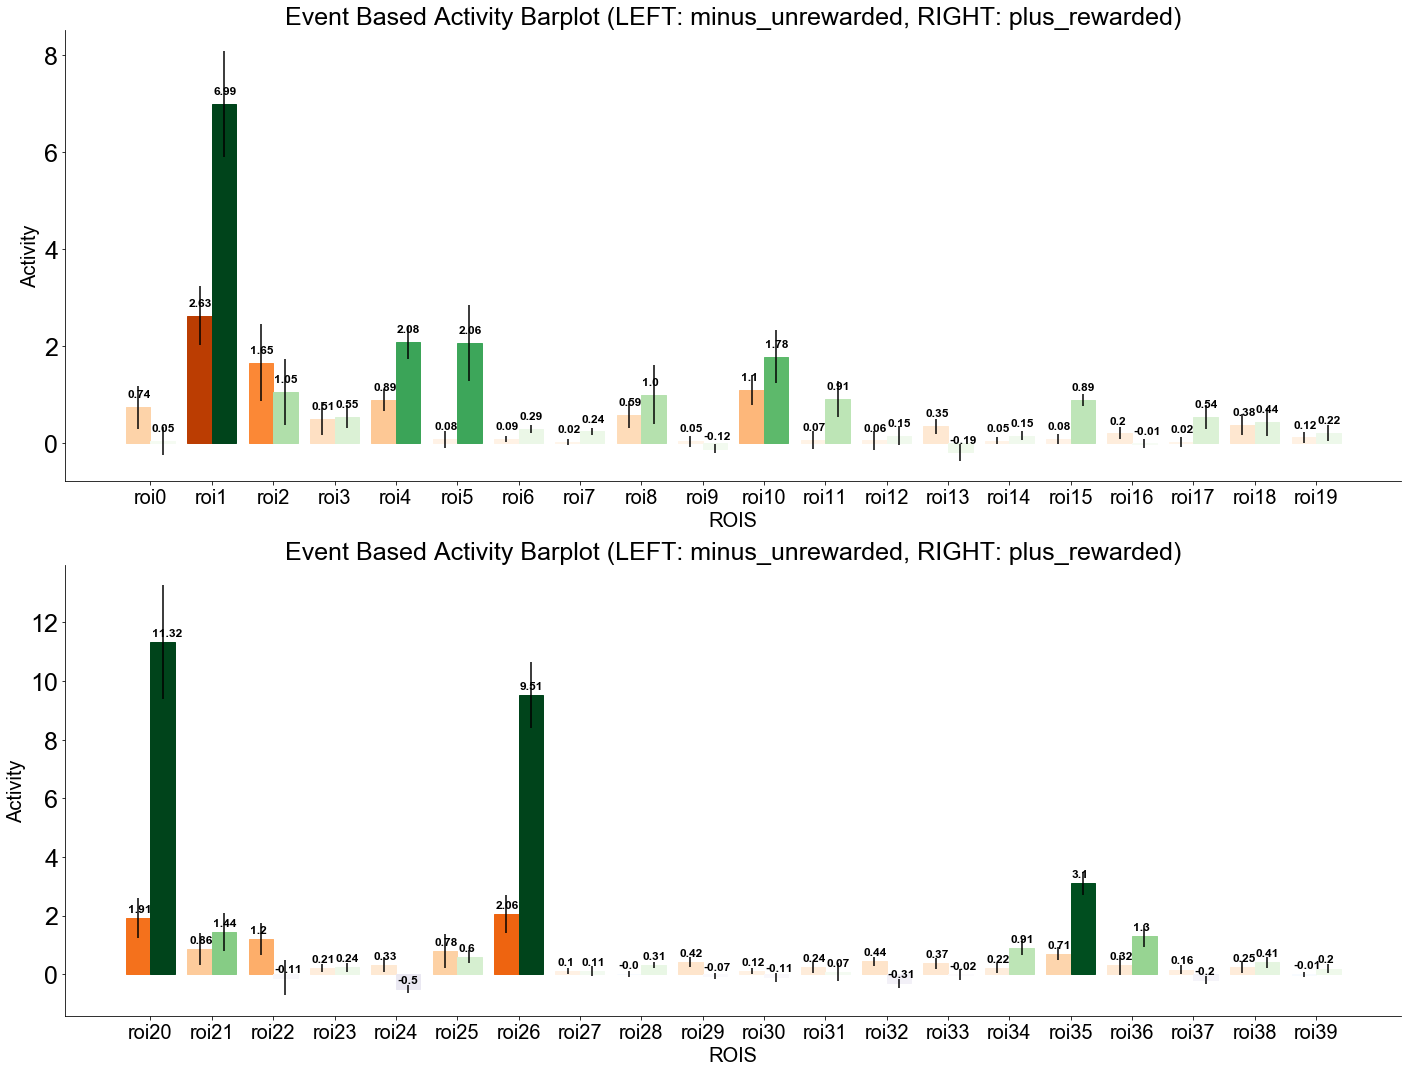

In [124]:
plt.rc('ytick',labelsize=25)

# creating two subplots, each containing plots for half of the data
(fig, axs) = plt.subplots(2, figsize=(20, 15))

# plot the barplot for first half of the data and add text
bars1 = plot_bars(axs, 0, subplot_rois[0], event_one, event_two, data, error_event_one, error_event_two)
add_text(axs, 0, subplot_rois[0], event_one, event_two)
# add colors to each bar in the barplot
add_colors(axs, bars1, 0, 1, data[event_one][subplot_rois[0]].values, data[event_one][subplot_rois[0]].values,
           contour_vector_event_one[subplot_rois[0]], contour_vector_event_two[subplot_rois[0]])
# decorate the barplot
plot_deco(axs, 0, subplot_rois[0], event_one, event_two);
# Hide the right and top spines
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)


# plot the barplot for first half of the data and add text
bars2 = plot_bars(axs, 1, subplot_rois[1], event_one, event_two, data, error_event_one, error_event_two)
add_text(axs, 1, subplot_rois[1], event_one, event_two)
# add colors to each bar in the barplot
add_colors(axs, bars2, 0, 1, data[event_one][subplot_rois[1]].values, data[event_two][subplot_rois[1]].values,
           contour_vector_event_one[subplot_rois[1]], contour_vector_event_two[subplot_rois[1]])
# decorate the barplot
plot_deco(axs, 1, subplot_rois[1], event_one, event_two);
# Hide the right and top spines
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

fig.tight_layout()

In [ ]:
# prepare to split data into chunks when loading to reduce memory imprint
num_rois = 50
group_size = 20.0
n_groups = int(np.ceil(num_rois/group_size))
group_roi_idx = np.array_split(np.arange(num_rois), n_groups) # split frame indices into chunks